# 整数長ジョブシーケンス問題

ここではJijSolverとJijModelingを用いて、長さが整数のジョブシーケンス問題を解いてみましょう。
この問題は、[Lucas, 2014, "Ising formulations of many NP problems"](https://www.frontiersin.org/articles/10.3389/fphy.2014.00005/full)の6.3. Job Sequencing with Integer Lengthsでも触れられています。

<!-- # Job Sequencing Problem with Integer Lengths

Here we show how to solve job sequencing problems with integer lengths using JijSolver and JijModeling. 
This problem is also described in 6.3. Job Sequencing with Integer Lengths on [Lucas, 2014, "Ising formulations of many NP problems"](https://www.frontiersin.org/articles/10.3389/fphy.2014.00005/full). -->

## 整数長ジョブシーケンス問題とは

タスク1は1時間の実行時間、タスク2は3時間の実行時間、のように、整数長のタスクがいくつかあるような場合を考えましょう。
「これらのタスクを複数コンピュータに分散させる場合、偏りを生じさせることなく、これらのコンピュータの実行時間を最適に分散させるにはどうすれば良いか？」を求める問題です。

<!-- ## What is Job Sequencing Problem with Integer Lengths?

We consider several tasks with integer lengths (i.e., task 1 takes one hour to execute on a computer, task 2 takes three hours, and so on).
We ask: when distributing these tasks to multiple computers, what combinations can be the optimal solution to distribute these computers' execution time without creating bias?
 -->

### 例

次のような問題を考えてみましょう。

> 10個のタスクを、3台のコンピュータに分散させることを考えましょう。
> 10個のタスクの長さはそれぞれ、1, 2, ..., 10であるとします。
> 私たちの目的は、3つのコンピュータの最大実行時間を、最小化するような解を求めることです。
> この場合、最適解は$\{1, 2, 7, 8\}, \{3, 4, 5, 6\}, \{9, 10\}$などがあり、この場合のコンピュータ実行時間の最大値は19となります。

![](./assets/integer_jobs_01.png)

<!-- ### Example

Let's take a look at the following situation.

> Here are 10 tasks and 3 computers. 
> The length of each of the 10 tasks is 1, 2, ..., 10.
> Our goal is to assign these tasks to the computers and minimize the maximum amount of time the tasks take.
> In this case, the optimal solution is $\{1, 2, 7, 8\}, \{3, 4, 5, 6\}$ and $\{9, 10\}$, whose maximum of execution time of computers is 19.

![](./assets/integer_jobs_01.png)
 -->

### 一般化

次に、$N$個のタスク($\{0, 1, \dots, N-1\}$)について考えることにしましょう。
これらのタスクの実行時間は$\bm{L}= \{L_0, L_1, \dots, L_{N-1}\}$とします。
$M$個のコンピュータが与えられたとき、$j$番目のコンピュータに割り当てられたタスクの集合を$V_j$としたとき、$j$番目のコンピュータに割り当てられたタスクの総実行時間は$A_j = \sum_{i \in V_j} L_i$のようになります。
そして$i$番目のタスクを$j$番目のコンピュータに割り当てるとき1、そうでないとき0となるバイナリ変数を$x_{i, j}$のように書くことにしましょう。

<!-- ### Generalization

Next, we introcude $N$ tasks $\{0, 1, ..., N-1\}$ and list of the execution time $\bm{L} = \{L_0, L_1, ..., L_{N-1}\}$. 
Given $M$ computers, the total execution time of $j$-th computer to perform its assigned tasks is $A_j = \sum_{i \in V_j} L_i$ where $V_j$ is a set of assigned tasks to $j$-th computer.
Finally, let us denote $x_{i, j}$ to be a binary variable which is 1 if $i$-th task is assigned to $j$-th computer, and 0 otherwise.
 -->

**制約: 各タスクはいずれか1つのコンピュータに割り当てられなければならない**

例えば、5番目のタスクを、1番目と2番目のコンピュータに同時に割り当てることはできません。
これを数式で表現すると、以下のようになります。

$$
\sum_{j=0}^{M-1} x_{i, j} = 1 \quad (\forall i \in \{0, 1, ..., N-1\}) \tag{1}
$$

<!-- **Constraint: each task must be assigned to one computer**

For instance, it is forbidden to assign the 5th task to the 1st and 2nd computers simultaneously.
We express this constraint as follows:

$$
\sum_{j=0}^{M-1} x_{i, j} = 1 \quad (\forall i \in \{0, 1, ..., N-1\}) \tag{1}
$$
 -->

**目的関数: 0番目のコンピュータと他のコンピュータとの層実行時間の差を最小化する**

0番目のコンピュータの総実行時間を基準として扱い、それと他のコンピュータとの差を最小化することを考えましょう。
これにより、実行時間のばらつきが小さくなり、タスクが均等に分散されます。

$$
\min \quad \sum_{j=1}^{M-1} (A_0 - A_j)^2 \tag{2}
$$

<!-- **Objective function: minimize the difference between the execution time of the 0th computer and others**

We consider the execution time of the 0th computer as the reference and minimize the difference between it and others.
This reduces the execution time variability and tasks are distributed equally.

$$
\min \quad \sum_{j=1}^{M-1} (A_0 - A_j)^2 \tag{2}
$$ -->

## JijModelingを用いたモデル化

次に、JijModelingを用いた実装を説明します。
まずは上述の数理モデルで用いる変数を定義しましょう。

<!-- ## Modeling by JijModeling

Next, we show an implementation using JijModeling. We first define variables for the mathematical model described above. -->

In [1]:
import jijmodeling as jm

# defin variables
L = jm.Placeholder('L', ndim=1)
N = L.len_at(0, latex="N")
M = jm.Placeholder('M')
x = jm.BinaryVar('x', shape=(N, M))
i = jm.Element('i', belong_to=(0, N))
j = jm.Element('j', belong_to=(0, M))

`L`は各タスクの実行時間を表す1次元配列です。
`N`はタスク数を表します。
`M`はコンピュータの数を表します。
そして、$x$は2次元のバイナリ変数列を表します。
最後に、数理モデルで用いる添字`i`, `j`を設定します。

<!-- `L` is a one-dimensional array representing the execution time of each task.
`N` denotes the number of tasks.
`M` is the number of computers.
Then, we define a two-dimensional list of binary variables `x`. 
Finally, we set the subscripts `i` and `j` used in the mathematical model. -->

### 制約

式(1)の制約を実装しましょう。

<!-- ### Constraint

We implement a constraint Equation (1). -->

In [2]:
# set problem
problem = jm.Problem('Integer Jobs')
# set constraint: job must be executed using a certain node
problem += jm.Constraint('onehot', x[i, :].sum()==1, forall=i)

`x[i, :].sum()`は`sum(j, x[i, j])`の糖衣構文です。

<!-- `x[i, :].sum()` is syntactic sugar of `sum(j, x[i, j])`. -->

### 目的関数

次に、式(2)の目的関数を実装します。

<!-- ### Objective function

Next, we implement an objective function Equation (2). -->

In [3]:
# set objective function: minimize difference between node 0 and others
A_0 = jm.sum(i, L[i]*x[i, 0])
A_j = jm.sum(i, L[i]*x[i, j])
problem += jm.sum((j, j!=0), (A_0 - A_j) ** 2)

`sum((j, j!=0), ...)`は$j \neq 0$以外の$j$で総和を取ることを意味します。

<!-- `sum((j, j!=0), ...)` denotes taking the sum of all cases where j is not 0. -->

実装した数理モデルを、Jupyter Notebook上で表示してみましょう。

<!-- Let's display the implemented mathematical model in Jupyter Notebook. -->

In [4]:
problem

## インスタンスの準備

各ジョブの実行時間と、コンピュータ数を設定しましょう。
ここでは、先ほど述べた10個のタスクと3台のコンピュータの場合を用います。

<!-- ## Prepare an instance

We set the execution time of each job and the number of computers.
At this time, we use the same values from an example as we describe before. -->

In [5]:
# set a list of jobs
inst_L = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# set the number of Nodes
inst_M = 3
instance_data = {'L': inst_L, 'M': inst_M}

## JijSolverで解く

`jijsolver`を用いて、この問題を解いてみましょう。

<!-- ## Solve by JijSolver

We solve this problem using `jijsolver`. -->

In [6]:
import jijsolver

interpreter = jm.Interpreter(instance_data)
instance = interpreter.eval_problem(problem)
solution = jijsolver.solve(instance, time_limit_sec=1.0)

## 解の可視化

最後に、得られた解を可視化してみましょう。

<!-- ## Visualize the solution

In the end, we visualize the solution obtained. -->

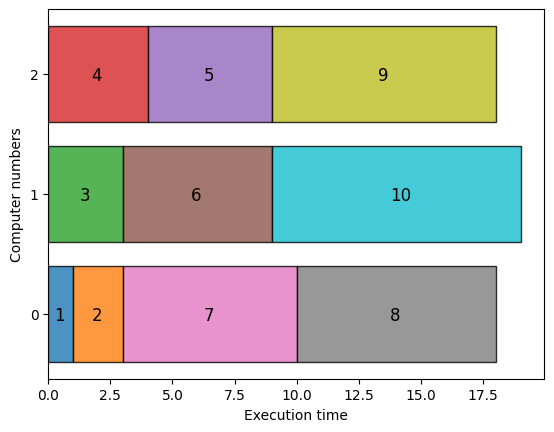

In [7]:
import matplotlib.pyplot as plt
import numpy as np

df = solution.decision_variables
x_indices = df[df["value"]==1]["subscripts"].to_list()
# get the instance information
L = instance_data["L"]
M = instance_data["M"]
# initialize execution time
exec_time = np.zeros(M, dtype=np.int64)
# compute summation of execution time each nodes
for i, j in x_indices:
    plt.barh(j, L[i], left=exec_time[j],ec="k", linewidth=1,alpha=0.8)
    plt.text(exec_time[j] + L[i] / 2.0 - 0.25 ,j-0.05, str(i+1),fontsize=12)
    exec_time[j] += L[i]
plt.yticks(range(M))
plt.ylabel('Computer numbers')
plt.xlabel('Execution time')
plt.show()

可視化されたグラフから、実行時間が3台のコンピュータに分散されていることがわかります。
この場合の実行時間の最大値は19であることから、最適解が得られていることもわかります。

<!-- With the above visualization, we obtain a graph where the execution times of three computers are approximately equal.
The maximum execution time is still 19, so this is optimal solution. -->